# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

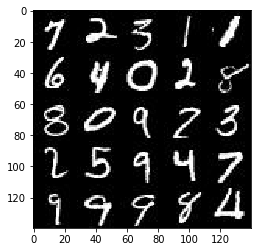

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

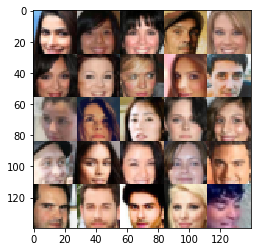

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(
        tf.float32, 
        [None, image_width, image_height, image_channels], 
        name="input_real")
    
    input_z = tf.placeholder(
        tf.float32, 
        [None, z_dim], 
        name="input_z")
    
    learning_rate = tf.placeholder(tf.float32, [], name="learning_rate")

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.1

    with tf.variable_scope('discriminator', reuse=reuse):
        
        conv1 = tf.layers.conv2d(images, 32, 5, 2, 'same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        max1 = tf.maximum(alpha * conv1, conv1)
        
        
        conv2 = tf.layers.conv2d(max1, 64, 5, 2, 'same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        norm1 = tf.layers.batch_normalization(conv2, training=True)
        max2 = tf.maximum(alpha * norm1, norm1)
        
        
        conv3 = tf.layers.conv2d(max2, 128, 5, 2, 'same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        norm2 = tf.layers.batch_normalization(conv3, training=True)
        max3 = tf.maximum(alpha * norm2, norm2)
        
        
        conv4 = tf.layers.conv2d(max3, 256, 5, 2, 'same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        norm3 = tf.layers.batch_normalization(conv4, training=True)
        max4 = tf.maximum(alpha * norm3, norm3)
        
        flat = tf.reshape(max4, (-1, 2*2*256))
        
        logits = tf.layers.dense(flat, 1)     
                
    return tf.sigmoid(logits), logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.1
    
    with tf.variable_scope("generator", reuse= not is_train):
        
        fully_connected = tf.layers.dense(z, 4*4*512)
        reshape = tf.reshape(fully_connected, (-1, 4, 4, 512))
        
        norm1 = tf.layers.batch_normalization(reshape, training=is_train)
        max1 = tf.maximum(alpha * norm1, norm1)
        
        deconv1 = tf.layers.conv2d_transpose(max1, 128, 4, strides=1, padding='valid')
        norm2 = tf.layers.batch_normalization(deconv1, training=is_train)
        max2 = tf.maximum(alpha * norm2, norm2)
        
        deconv2 = tf.layers.conv2d_transpose(max2, 64, 5, 2, 'same')
        norm3 = tf.layers.batch_normalization(deconv2, training=is_train)
        max3 = tf.maximum(alpha * norm3, norm3)
        
        deconv3 = tf.layers.conv2d_transpose(max3, 32, 5, 2, 'same')
        norm4 = tf.layers.batch_normalization(deconv3, training=is_train)
        max4 = tf.maximum(alpha * norm4, norm4)
 
        logits = tf.layers.conv2d_transpose(max4, out_channel_dim, 3, 1, 'same')
        
    return tf.tanh(logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    gen = generator(input_z, out_channel_dim)
    
    _ , dis_logits_real = discriminator(input_real)
    _ , dis_logits_fake = discriminator(gen, reuse=True)
    
    # Losses
    dis_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                                                logits=dis_logits_real,
                                                labels=tf.ones_like(dis_logits_real) * 0.9))
    
    dis_loss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                                                logits=dis_logits_fake,
                                                labels=tf.zeros_like(dis_logits_fake)))
        
    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                                                logits=dis_logits_fake,
                                                labels=tf.ones_like(dis_logits_fake)))
    
    return dis_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    gen_vars = [var for var in tf.trainable_variables() if var.name.startswith('generator')]
    dir_vars = [var for var in tf.trainable_variables() if var.name.startswith('discriminator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        gen_optimizer = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
        dis_optimizer = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=dir_vars)
        
    return dis_optimizer, gen_optimizer


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    out_channel_dim = 3
    
    if data_image_mode == "L":
        out_channel_dim = 1
        
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    dis_loss, gen_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(dis_loss, gen_loss, learning_rate, beta1)
    
    steps = 0
    show_epoch = 20
    show_picture = 100

    with tf.Session() as sess:
        
        sess.run(tf.global_variables_initializer())
        
        for epoch_i in range(epoch_count):
            
            for batch_images in get_batches(batch_size):
            
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images *= 2 
                 
                _ = sess.run(d_train_opt,
                             feed_dict={input_z: batch_z,
                                        input_real: batch_images,
                                        learn_rate: learning_rate})
                
                _ = sess.run(g_train_opt, 
                             feed_dict={input_z: batch_z, 
                                        input_real: batch_images,
                                        learn_rate: learning_rate})
                
                if steps % show_epoch == 0:
                    train_loss_d = dis_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = gen_loss.eval({input_z: batch_z})
                    print("Epoch {}/{} - ".format(epoch_i+1, epochs),
                          "Discriminator: {:.4f} - ".format(train_loss_d),
                          "Generator: {:.4f}".format(train_loss_g))

                if steps % show_picture == 0:
                    gen_samples = sess.run(
                                   generator(input_z, data_shape[3], is_train = False),
                                   feed_dict={input_z: batch_z})
                    _ = show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                    
                steps += 1

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 -  Discriminator: 2.3490 -  Generator: 0.2374


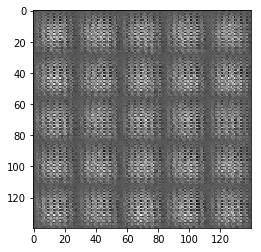

Epoch 1/2 -  Discriminator: 1.1785 -  Generator: 0.6467
Epoch 1/2 -  Discriminator: 1.0024 -  Generator: 1.1354
Epoch 1/2 -  Discriminator: 1.2079 -  Generator: 0.6292
Epoch 1/2 -  Discriminator: 1.8899 -  Generator: 2.7277
Epoch 1/2 -  Discriminator: 1.7336 -  Generator: 0.3028


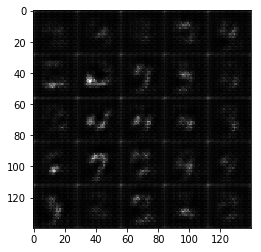

Epoch 1/2 -  Discriminator: 1.4959 -  Generator: 0.6060
Epoch 1/2 -  Discriminator: 1.4288 -  Generator: 0.7589
Epoch 1/2 -  Discriminator: 1.4742 -  Generator: 0.4891
Epoch 1/2 -  Discriminator: 1.3427 -  Generator: 1.1179
Epoch 1/2 -  Discriminator: 1.3917 -  Generator: 1.3683


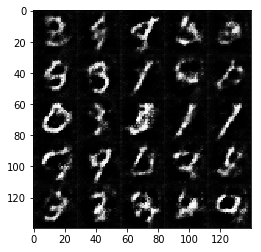

Epoch 1/2 -  Discriminator: 1.3517 -  Generator: 1.0337
Epoch 1/2 -  Discriminator: 1.3057 -  Generator: 1.3591
Epoch 1/2 -  Discriminator: 1.3269 -  Generator: 1.0960
Epoch 1/2 -  Discriminator: 1.5835 -  Generator: 0.3865
Epoch 1/2 -  Discriminator: 1.6319 -  Generator: 0.3504


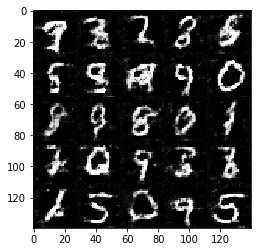

Epoch 1/2 -  Discriminator: 1.4793 -  Generator: 0.4314
Epoch 1/2 -  Discriminator: 1.4515 -  Generator: 1.2807
Epoch 1/2 -  Discriminator: 1.3063 -  Generator: 0.6504
Epoch 1/2 -  Discriminator: 1.2984 -  Generator: 0.7986
Epoch 1/2 -  Discriminator: 1.4792 -  Generator: 0.4822


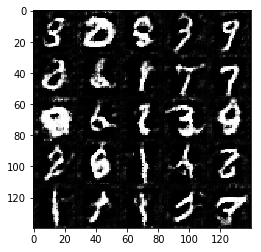

Epoch 1/2 -  Discriminator: 1.3630 -  Generator: 0.5452
Epoch 1/2 -  Discriminator: 1.2755 -  Generator: 0.6818
Epoch 1/2 -  Discriminator: 1.4509 -  Generator: 0.4730
Epoch 1/2 -  Discriminator: 1.3017 -  Generator: 0.8781
Epoch 1/2 -  Discriminator: 1.2888 -  Generator: 0.7670


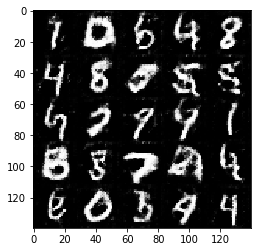

Epoch 1/2 -  Discriminator: 1.3325 -  Generator: 0.5581
Epoch 1/2 -  Discriminator: 1.4098 -  Generator: 0.4961
Epoch 1/2 -  Discriminator: 1.8084 -  Generator: 0.2778
Epoch 1/2 -  Discriminator: 1.2533 -  Generator: 1.0870
Epoch 1/2 -  Discriminator: 1.3965 -  Generator: 0.5225


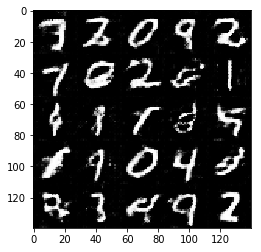

Epoch 1/2 -  Discriminator: 1.2431 -  Generator: 0.7597
Epoch 1/2 -  Discriminator: 1.2335 -  Generator: 0.8874
Epoch 1/2 -  Discriminator: 1.4911 -  Generator: 0.4868
Epoch 1/2 -  Discriminator: 1.5393 -  Generator: 0.4117
Epoch 1/2 -  Discriminator: 1.5468 -  Generator: 1.7699


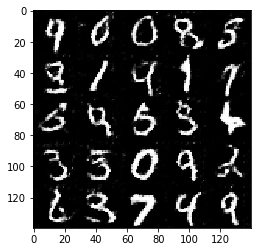

Epoch 1/2 -  Discriminator: 1.4626 -  Generator: 1.5096
Epoch 1/2 -  Discriminator: 1.1431 -  Generator: 0.9540
Epoch 1/2 -  Discriminator: 1.5635 -  Generator: 0.3757
Epoch 1/2 -  Discriminator: 1.0485 -  Generator: 1.0667
Epoch 1/2 -  Discriminator: 1.2994 -  Generator: 0.6391


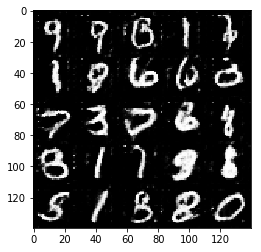

Epoch 1/2 -  Discriminator: 1.2854 -  Generator: 0.6212
Epoch 1/2 -  Discriminator: 1.7810 -  Generator: 0.3101
Epoch 1/2 -  Discriminator: 1.4642 -  Generator: 0.4630
Epoch 1/2 -  Discriminator: 1.3834 -  Generator: 0.4922
Epoch 1/2 -  Discriminator: 1.7098 -  Generator: 1.8940


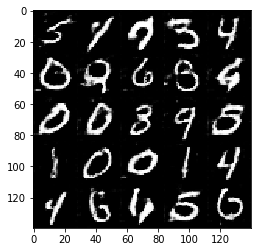

Epoch 1/2 -  Discriminator: 1.6002 -  Generator: 0.3785
Epoch 2/2 -  Discriminator: 1.1856 -  Generator: 1.2745
Epoch 2/2 -  Discriminator: 1.4730 -  Generator: 1.9120
Epoch 2/2 -  Discriminator: 1.4056 -  Generator: 1.8394
Epoch 2/2 -  Discriminator: 1.2207 -  Generator: 0.7556


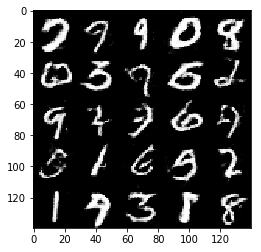

Epoch 2/2 -  Discriminator: 1.1792 -  Generator: 0.6630
Epoch 2/2 -  Discriminator: 1.5276 -  Generator: 0.4459
Epoch 2/2 -  Discriminator: 1.1724 -  Generator: 1.1942
Epoch 2/2 -  Discriminator: 1.2044 -  Generator: 1.1168
Epoch 2/2 -  Discriminator: 1.6375 -  Generator: 1.8308


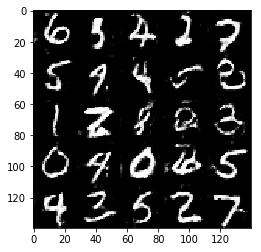

Epoch 2/2 -  Discriminator: 1.2843 -  Generator: 0.6284
Epoch 2/2 -  Discriminator: 1.2298 -  Generator: 1.0168
Epoch 2/2 -  Discriminator: 1.6639 -  Generator: 1.9969
Epoch 2/2 -  Discriminator: 2.1803 -  Generator: 0.1955
Epoch 2/2 -  Discriminator: 1.0776 -  Generator: 1.3179


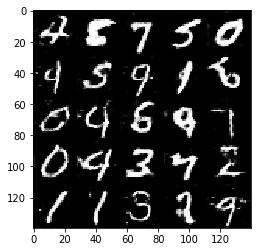

Epoch 2/2 -  Discriminator: 1.1879 -  Generator: 0.7121
Epoch 2/2 -  Discriminator: 1.2339 -  Generator: 1.0779
Epoch 2/2 -  Discriminator: 1.0634 -  Generator: 1.3170
Epoch 2/2 -  Discriminator: 1.1188 -  Generator: 0.8558
Epoch 2/2 -  Discriminator: 1.2982 -  Generator: 0.5876


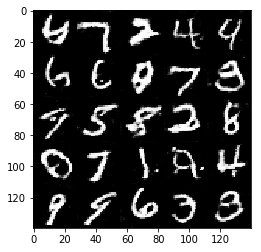

Epoch 2/2 -  Discriminator: 1.4915 -  Generator: 0.4377
Epoch 2/2 -  Discriminator: 1.4717 -  Generator: 1.8226
Epoch 2/2 -  Discriminator: 2.1570 -  Generator: 0.2032
Epoch 2/2 -  Discriminator: 0.9864 -  Generator: 1.1166
Epoch 2/2 -  Discriminator: 1.2984 -  Generator: 0.6449


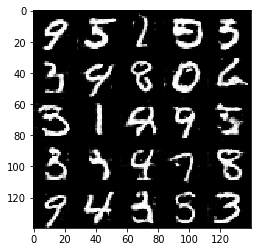

Epoch 2/2 -  Discriminator: 1.3047 -  Generator: 1.6409
Epoch 2/2 -  Discriminator: 1.4543 -  Generator: 0.4241
Epoch 2/2 -  Discriminator: 1.0544 -  Generator: 1.3758
Epoch 2/2 -  Discriminator: 1.2411 -  Generator: 0.6822
Epoch 2/2 -  Discriminator: 1.6081 -  Generator: 0.4287


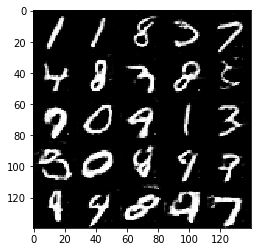

Epoch 2/2 -  Discriminator: 1.1618 -  Generator: 1.2882
Epoch 2/2 -  Discriminator: 1.3009 -  Generator: 0.6693
Epoch 2/2 -  Discriminator: 1.5135 -  Generator: 1.7464
Epoch 2/2 -  Discriminator: 1.4273 -  Generator: 0.4442
Epoch 2/2 -  Discriminator: 1.1386 -  Generator: 0.7718


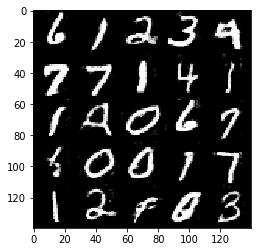

Epoch 2/2 -  Discriminator: 1.7629 -  Generator: 0.6762
Epoch 2/2 -  Discriminator: 1.6241 -  Generator: 0.5023
Epoch 2/2 -  Discriminator: 1.3481 -  Generator: 0.5119
Epoch 2/2 -  Discriminator: 1.5935 -  Generator: 0.3924
Epoch 2/2 -  Discriminator: 1.0460 -  Generator: 1.3062


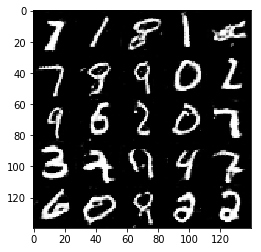

Epoch 2/2 -  Discriminator: 1.6360 -  Generator: 2.1572
Epoch 2/2 -  Discriminator: 1.0799 -  Generator: 0.9169
Epoch 2/2 -  Discriminator: 1.2739 -  Generator: 0.6724
Epoch 2/2 -  Discriminator: 0.8289 -  Generator: 1.5117
Epoch 2/2 -  Discriminator: 1.3427 -  Generator: 2.0567


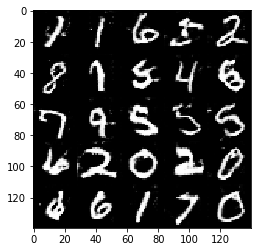

Epoch 2/2 -  Discriminator: 1.5007 -  Generator: 0.4160
Epoch 2/2 -  Discriminator: 1.0333 -  Generator: 1.1613
Epoch 2/2 -  Discriminator: 1.0580 -  Generator: 1.8071


In [13]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/3 -  Discriminator: 6.1704 -  Generator: 0.0071


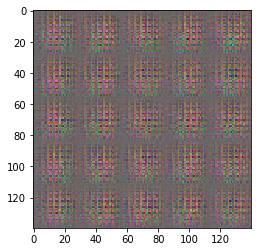

Epoch 1/3 -  Discriminator: 0.8861 -  Generator: 0.9556
Epoch 1/3 -  Discriminator: 1.5539 -  Generator: 0.4728
Epoch 1/3 -  Discriminator: 1.2747 -  Generator: 0.7514
Epoch 1/3 -  Discriminator: 1.2945 -  Generator: 0.7555
Epoch 1/3 -  Discriminator: 1.5120 -  Generator: 1.5832


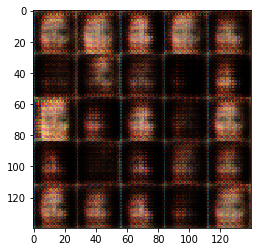

Epoch 1/3 -  Discriminator: 1.5761 -  Generator: 0.4059
Epoch 1/3 -  Discriminator: 1.2726 -  Generator: 0.6199
Epoch 1/3 -  Discriminator: 1.6584 -  Generator: 0.5350
Epoch 1/3 -  Discriminator: 1.6280 -  Generator: 0.3818
Epoch 1/3 -  Discriminator: 1.3733 -  Generator: 0.7553


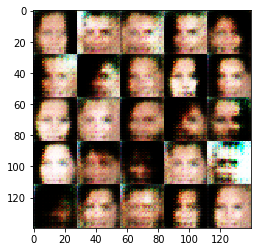

Epoch 1/3 -  Discriminator: 1.3178 -  Generator: 1.3842
Epoch 1/3 -  Discriminator: 1.2368 -  Generator: 0.8471
Epoch 1/3 -  Discriminator: 0.8690 -  Generator: 0.9993
Epoch 1/3 -  Discriminator: 0.8973 -  Generator: 1.2428
Epoch 1/3 -  Discriminator: 1.5077 -  Generator: 0.8652


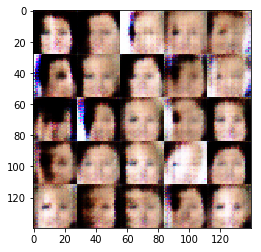

Epoch 1/3 -  Discriminator: 1.3822 -  Generator: 0.8165
Epoch 1/3 -  Discriminator: 1.2438 -  Generator: 1.0643
Epoch 1/3 -  Discriminator: 1.9796 -  Generator: 1.4927
Epoch 1/3 -  Discriminator: 1.6187 -  Generator: 0.4175
Epoch 1/3 -  Discriminator: 1.7789 -  Generator: 0.2856


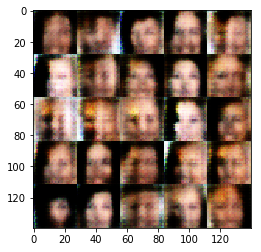

Epoch 1/3 -  Discriminator: 1.5912 -  Generator: 1.3459
Epoch 1/3 -  Discriminator: 1.4188 -  Generator: 0.8225
Epoch 1/3 -  Discriminator: 1.3760 -  Generator: 0.8440
Epoch 1/3 -  Discriminator: 1.5551 -  Generator: 1.3347
Epoch 1/3 -  Discriminator: 1.7317 -  Generator: 0.3669


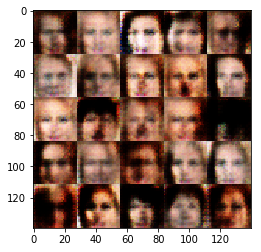

Epoch 1/3 -  Discriminator: 1.1752 -  Generator: 1.1071
Epoch 1/3 -  Discriminator: 1.2106 -  Generator: 0.7994
Epoch 1/3 -  Discriminator: 1.3425 -  Generator: 1.0488
Epoch 1/3 -  Discriminator: 1.2930 -  Generator: 1.1249
Epoch 1/3 -  Discriminator: 1.4234 -  Generator: 1.1042


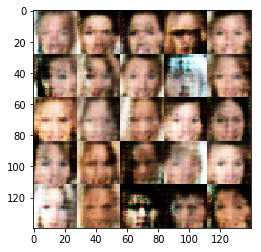

Epoch 1/3 -  Discriminator: 1.4627 -  Generator: 0.5363
Epoch 1/3 -  Discriminator: 1.1552 -  Generator: 1.0712
Epoch 1/3 -  Discriminator: 1.6676 -  Generator: 1.4707
Epoch 1/3 -  Discriminator: 1.2404 -  Generator: 1.3632
Epoch 1/3 -  Discriminator: 1.3716 -  Generator: 0.6192


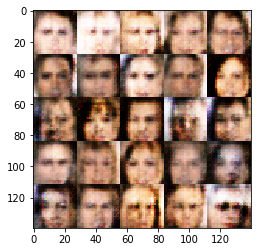

Epoch 1/3 -  Discriminator: 1.3412 -  Generator: 1.0234
Epoch 1/3 -  Discriminator: 1.1952 -  Generator: 0.9048
Epoch 1/3 -  Discriminator: 1.3439 -  Generator: 1.1756
Epoch 1/3 -  Discriminator: 1.2970 -  Generator: 1.0647
Epoch 1/3 -  Discriminator: 1.3608 -  Generator: 0.8539


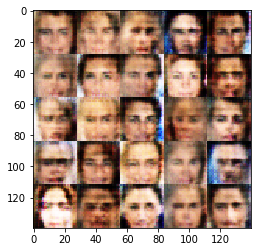

Epoch 1/3 -  Discriminator: 1.4565 -  Generator: 1.4386
Epoch 1/3 -  Discriminator: 1.3345 -  Generator: 1.0893
Epoch 1/3 -  Discriminator: 1.3172 -  Generator: 0.6675
Epoch 1/3 -  Discriminator: 1.2454 -  Generator: 0.7518
Epoch 1/3 -  Discriminator: 1.2674 -  Generator: 0.7705


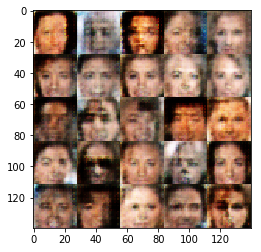

Epoch 1/3 -  Discriminator: 1.3830 -  Generator: 0.6158
Epoch 1/3 -  Discriminator: 1.5188 -  Generator: 0.5181
Epoch 1/3 -  Discriminator: 1.2735 -  Generator: 0.6161
Epoch 1/3 -  Discriminator: 1.3681 -  Generator: 0.5610
Epoch 1/3 -  Discriminator: 1.6358 -  Generator: 0.3798


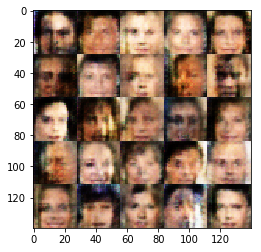

Epoch 1/3 -  Discriminator: 1.2760 -  Generator: 0.8429
Epoch 1/3 -  Discriminator: 1.7757 -  Generator: 0.3154
Epoch 1/3 -  Discriminator: 1.4567 -  Generator: 0.5431
Epoch 1/3 -  Discriminator: 1.3959 -  Generator: 0.6696
Epoch 1/3 -  Discriminator: 1.4971 -  Generator: 0.5135


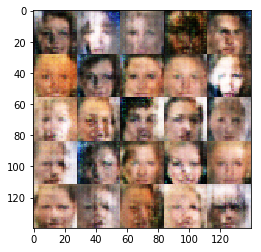

Epoch 1/3 -  Discriminator: 1.3823 -  Generator: 0.9595
Epoch 1/3 -  Discriminator: 1.8102 -  Generator: 0.3194
Epoch 1/3 -  Discriminator: 1.6215 -  Generator: 0.3888
Epoch 1/3 -  Discriminator: 1.2362 -  Generator: 0.8672
Epoch 1/3 -  Discriminator: 1.3104 -  Generator: 0.8908


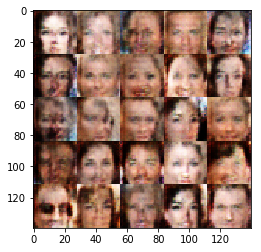

Epoch 1/3 -  Discriminator: 1.3674 -  Generator: 0.5248
Epoch 1/3 -  Discriminator: 1.4120 -  Generator: 0.5472
Epoch 1/3 -  Discriminator: 1.2115 -  Generator: 0.8029
Epoch 1/3 -  Discriminator: 1.5018 -  Generator: 0.4968
Epoch 1/3 -  Discriminator: 1.5168 -  Generator: 0.4383


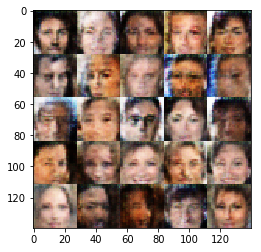

Epoch 1/3 -  Discriminator: 1.4441 -  Generator: 0.5128
Epoch 1/3 -  Discriminator: 1.5179 -  Generator: 0.4522
Epoch 1/3 -  Discriminator: 1.4932 -  Generator: 0.4571
Epoch 1/3 -  Discriminator: 1.4080 -  Generator: 0.5649
Epoch 1/3 -  Discriminator: 1.4512 -  Generator: 0.5524


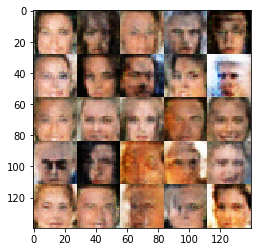

Epoch 1/3 -  Discriminator: 1.6315 -  Generator: 0.3984
Epoch 1/3 -  Discriminator: 1.3768 -  Generator: 0.5864
Epoch 1/3 -  Discriminator: 1.3008 -  Generator: 0.9399
Epoch 1/3 -  Discriminator: 1.4310 -  Generator: 0.5613
Epoch 1/3 -  Discriminator: 1.4812 -  Generator: 0.4723


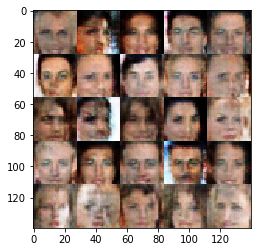

Epoch 1/3 -  Discriminator: 1.4044 -  Generator: 0.5620
Epoch 1/3 -  Discriminator: 1.4477 -  Generator: 0.5378
Epoch 1/3 -  Discriminator: 1.5536 -  Generator: 0.4497
Epoch 1/3 -  Discriminator: 1.3046 -  Generator: 0.9665
Epoch 1/3 -  Discriminator: 1.3949 -  Generator: 0.6582


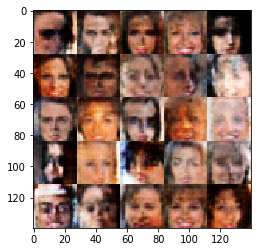

Epoch 1/3 -  Discriminator: 1.3471 -  Generator: 0.6154
Epoch 1/3 -  Discriminator: 1.3471 -  Generator: 0.7011
Epoch 1/3 -  Discriminator: 1.2543 -  Generator: 1.0123
Epoch 1/3 -  Discriminator: 1.7771 -  Generator: 0.3074
Epoch 1/3 -  Discriminator: 1.5156 -  Generator: 0.4690


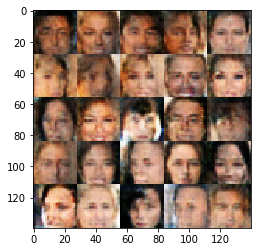

Epoch 1/3 -  Discriminator: 1.3489 -  Generator: 0.6387
Epoch 1/3 -  Discriminator: 1.3934 -  Generator: 0.6034
Epoch 1/3 -  Discriminator: 1.3741 -  Generator: 0.6359
Epoch 1/3 -  Discriminator: 1.7789 -  Generator: 0.3135
Epoch 1/3 -  Discriminator: 1.4257 -  Generator: 0.5787


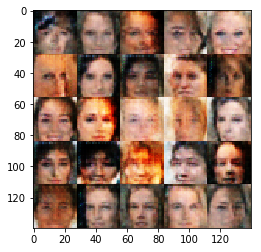

Epoch 1/3 -  Discriminator: 1.4534 -  Generator: 0.5666
Epoch 1/3 -  Discriminator: 1.5803 -  Generator: 0.4027
Epoch 1/3 -  Discriminator: 1.3073 -  Generator: 0.6697
Epoch 1/3 -  Discriminator: 1.4855 -  Generator: 0.4818
Epoch 1/3 -  Discriminator: 1.6903 -  Generator: 0.3378


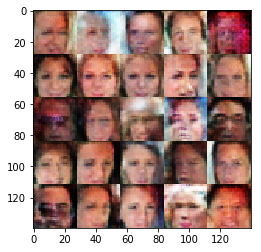

Epoch 1/3 -  Discriminator: 1.5861 -  Generator: 0.4198
Epoch 1/3 -  Discriminator: 1.3848 -  Generator: 0.6520
Epoch 1/3 -  Discriminator: 1.3967 -  Generator: 1.3143
Epoch 1/3 -  Discriminator: 1.4500 -  Generator: 0.5580
Epoch 1/3 -  Discriminator: 1.3191 -  Generator: 0.6470


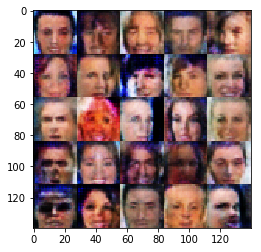

Epoch 1/3 -  Discriminator: 1.5054 -  Generator: 0.4533
Epoch 1/3 -  Discriminator: 1.4810 -  Generator: 0.4661
Epoch 1/3 -  Discriminator: 1.6690 -  Generator: 0.3809
Epoch 1/3 -  Discriminator: 1.9798 -  Generator: 0.2510
Epoch 1/3 -  Discriminator: 1.5181 -  Generator: 0.4489


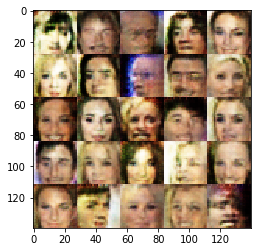

Epoch 1/3 -  Discriminator: 1.4890 -  Generator: 0.5280
Epoch 1/3 -  Discriminator: 1.2121 -  Generator: 1.1790
Epoch 1/3 -  Discriminator: 1.3108 -  Generator: 1.0592
Epoch 1/3 -  Discriminator: 1.7251 -  Generator: 0.3547
Epoch 1/3 -  Discriminator: 1.6201 -  Generator: 0.3950


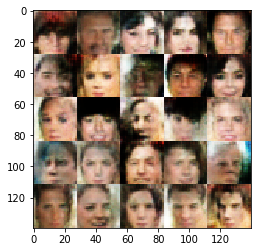

Epoch 1/3 -  Discriminator: 1.3296 -  Generator: 0.9906
Epoch 1/3 -  Discriminator: 1.4043 -  Generator: 0.8984
Epoch 1/3 -  Discriminator: 1.2803 -  Generator: 1.0728
Epoch 1/3 -  Discriminator: 1.6579 -  Generator: 0.3895
Epoch 1/3 -  Discriminator: 1.2556 -  Generator: 0.9118


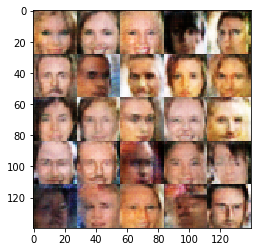

Epoch 1/3 -  Discriminator: 1.5567 -  Generator: 0.4319
Epoch 1/3 -  Discriminator: 1.2292 -  Generator: 0.6873
Epoch 1/3 -  Discriminator: 1.4009 -  Generator: 0.6737
Epoch 1/3 -  Discriminator: 1.4743 -  Generator: 0.4971
Epoch 1/3 -  Discriminator: 1.3480 -  Generator: 0.7924


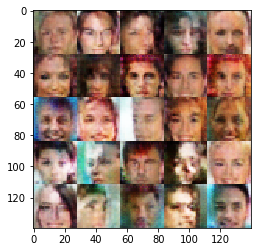

Epoch 1/3 -  Discriminator: 1.4668 -  Generator: 0.5116
Epoch 1/3 -  Discriminator: 1.3700 -  Generator: 1.0812
Epoch 1/3 -  Discriminator: 1.3675 -  Generator: 0.6332
Epoch 1/3 -  Discriminator: 1.4824 -  Generator: 0.4571
Epoch 1/3 -  Discriminator: 1.6604 -  Generator: 0.3551


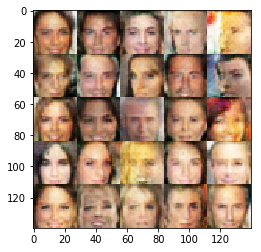

Epoch 1/3 -  Discriminator: 1.3056 -  Generator: 0.6536
Epoch 1/3 -  Discriminator: 1.4376 -  Generator: 0.5566
Epoch 1/3 -  Discriminator: 1.6159 -  Generator: 0.3957
Epoch 1/3 -  Discriminator: 1.5922 -  Generator: 0.4121
Epoch 1/3 -  Discriminator: 1.8320 -  Generator: 0.2800


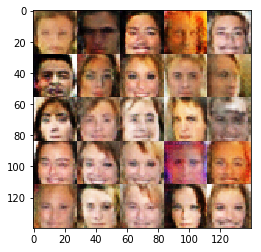

Epoch 1/3 -  Discriminator: 1.4653 -  Generator: 0.4633
Epoch 1/3 -  Discriminator: 1.5900 -  Generator: 0.4460
Epoch 1/3 -  Discriminator: 1.8078 -  Generator: 0.3121
Epoch 1/3 -  Discriminator: 1.2210 -  Generator: 0.8916
Epoch 1/3 -  Discriminator: 1.4733 -  Generator: 0.4705


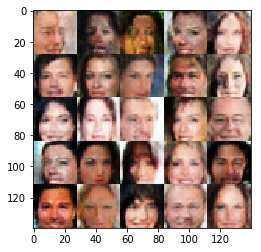

Epoch 1/3 -  Discriminator: 1.6971 -  Generator: 0.3548
Epoch 1/3 -  Discriminator: 1.5394 -  Generator: 0.4188
Epoch 1/3 -  Discriminator: 1.7604 -  Generator: 0.3344
Epoch 1/3 -  Discriminator: 1.5142 -  Generator: 0.5242
Epoch 1/3 -  Discriminator: 1.6418 -  Generator: 0.3588


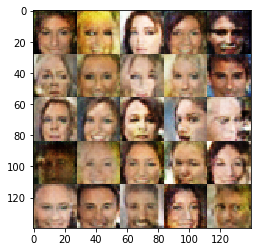

Epoch 1/3 -  Discriminator: 1.5336 -  Generator: 0.4642
Epoch 1/3 -  Discriminator: 1.8320 -  Generator: 0.2943
Epoch 1/3 -  Discriminator: 1.5743 -  Generator: 0.4180
Epoch 1/3 -  Discriminator: 1.7555 -  Generator: 0.3124
Epoch 1/3 -  Discriminator: 1.6225 -  Generator: 0.3822


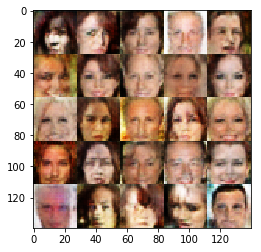

Epoch 1/3 -  Discriminator: 1.3355 -  Generator: 0.7069
Epoch 1/3 -  Discriminator: 1.4735 -  Generator: 0.4578
Epoch 1/3 -  Discriminator: 1.7278 -  Generator: 0.3365
Epoch 1/3 -  Discriminator: 1.3008 -  Generator: 0.8084
Epoch 1/3 -  Discriminator: 1.2053 -  Generator: 0.9300


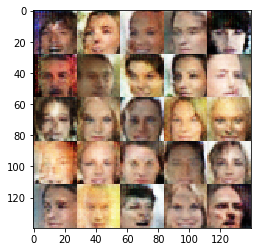

Epoch 1/3 -  Discriminator: 1.4245 -  Generator: 0.5499
Epoch 1/3 -  Discriminator: 1.4489 -  Generator: 0.5081
Epoch 1/3 -  Discriminator: 1.1977 -  Generator: 0.6729
Epoch 1/3 -  Discriminator: 1.5471 -  Generator: 0.4485
Epoch 1/3 -  Discriminator: 1.2777 -  Generator: 0.7930


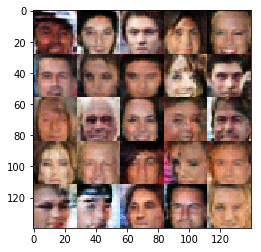

Epoch 1/3 -  Discriminator: 1.8669 -  Generator: 0.2836
Epoch 1/3 -  Discriminator: 1.4143 -  Generator: 0.6699
Epoch 1/3 -  Discriminator: 1.3934 -  Generator: 0.5085
Epoch 2/3 -  Discriminator: 1.3337 -  Generator: 0.9419
Epoch 2/3 -  Discriminator: 1.4965 -  Generator: 0.4395


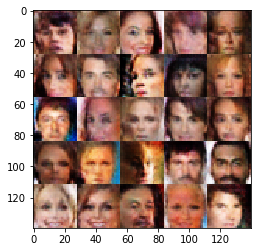

Epoch 2/3 -  Discriminator: 1.4468 -  Generator: 0.7882
Epoch 2/3 -  Discriminator: 1.6531 -  Generator: 0.3634
Epoch 2/3 -  Discriminator: 1.2646 -  Generator: 0.5953
Epoch 2/3 -  Discriminator: 1.5293 -  Generator: 0.4679
Epoch 2/3 -  Discriminator: 1.3720 -  Generator: 0.6047


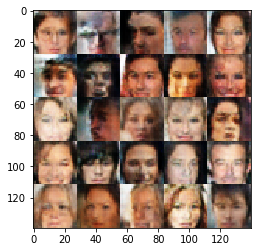

Epoch 2/3 -  Discriminator: 1.4232 -  Generator: 1.0752
Epoch 2/3 -  Discriminator: 1.7506 -  Generator: 0.3151
Epoch 2/3 -  Discriminator: 1.7473 -  Generator: 0.3208
Epoch 2/3 -  Discriminator: 1.3523 -  Generator: 0.5801
Epoch 2/3 -  Discriminator: 1.6465 -  Generator: 0.3603


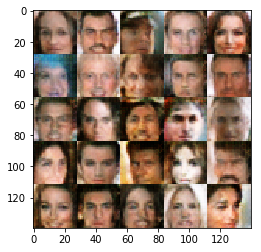

Epoch 2/3 -  Discriminator: 1.6196 -  Generator: 0.3846
Epoch 2/3 -  Discriminator: 1.3439 -  Generator: 0.7147
Epoch 2/3 -  Discriminator: 1.7869 -  Generator: 0.3168
Epoch 2/3 -  Discriminator: 1.4538 -  Generator: 0.9778
Epoch 2/3 -  Discriminator: 1.3234 -  Generator: 0.5742


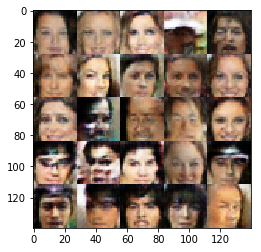

Epoch 2/3 -  Discriminator: 1.3660 -  Generator: 0.6257
Epoch 2/3 -  Discriminator: 1.5039 -  Generator: 0.4423
Epoch 2/3 -  Discriminator: 1.3336 -  Generator: 0.6062
Epoch 2/3 -  Discriminator: 1.2974 -  Generator: 0.7294
Epoch 2/3 -  Discriminator: 1.2174 -  Generator: 0.9266


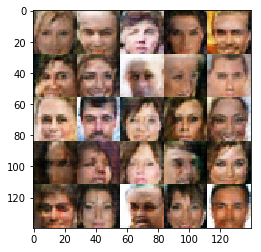

Epoch 2/3 -  Discriminator: 1.6581 -  Generator: 0.3531
Epoch 2/3 -  Discriminator: 1.2386 -  Generator: 0.8231
Epoch 2/3 -  Discriminator: 1.4321 -  Generator: 0.5632
Epoch 2/3 -  Discriminator: 1.2559 -  Generator: 1.0388
Epoch 2/3 -  Discriminator: 1.2979 -  Generator: 0.6829


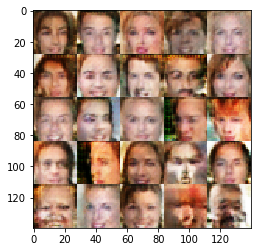

Epoch 2/3 -  Discriminator: 1.3928 -  Generator: 0.5340
Epoch 2/3 -  Discriminator: 1.9093 -  Generator: 0.2733
Epoch 2/3 -  Discriminator: 1.2759 -  Generator: 0.8211
Epoch 2/3 -  Discriminator: 1.5507 -  Generator: 0.4209
Epoch 2/3 -  Discriminator: 1.9203 -  Generator: 0.2935


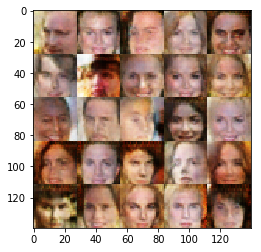

Epoch 2/3 -  Discriminator: 1.3197 -  Generator: 0.6413
Epoch 2/3 -  Discriminator: 1.5501 -  Generator: 0.4016
Epoch 2/3 -  Discriminator: 1.7923 -  Generator: 0.3075
Epoch 2/3 -  Discriminator: 1.5591 -  Generator: 0.4284
Epoch 2/3 -  Discriminator: 1.5229 -  Generator: 1.6393


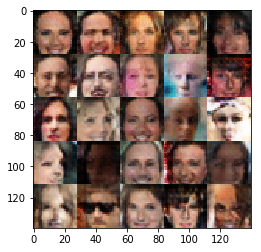

Epoch 2/3 -  Discriminator: 1.1923 -  Generator: 0.9895
Epoch 2/3 -  Discriminator: 1.3350 -  Generator: 0.7514
Epoch 2/3 -  Discriminator: 1.4403 -  Generator: 0.5273
Epoch 2/3 -  Discriminator: 1.5542 -  Generator: 0.4175
Epoch 2/3 -  Discriminator: 1.6185 -  Generator: 0.3936


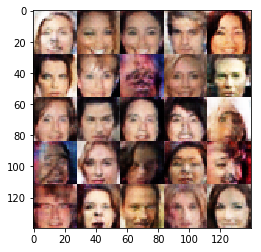

Epoch 2/3 -  Discriminator: 1.8279 -  Generator: 0.2863
Epoch 2/3 -  Discriminator: 1.4513 -  Generator: 0.5113
Epoch 2/3 -  Discriminator: 1.2723 -  Generator: 0.8510
Epoch 2/3 -  Discriminator: 1.6543 -  Generator: 0.3703
Epoch 2/3 -  Discriminator: 1.6172 -  Generator: 0.3938


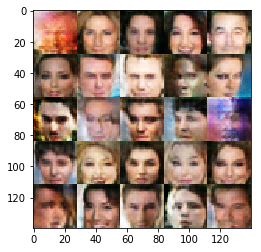

Epoch 2/3 -  Discriminator: 1.4718 -  Generator: 0.4879
Epoch 2/3 -  Discriminator: 1.7757 -  Generator: 0.3824
Epoch 2/3 -  Discriminator: 1.5384 -  Generator: 0.4266
Epoch 2/3 -  Discriminator: 1.2993 -  Generator: 0.6514
Epoch 2/3 -  Discriminator: 1.2806 -  Generator: 0.7650


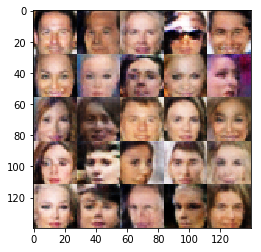

Epoch 2/3 -  Discriminator: 1.5776 -  Generator: 0.3917
Epoch 2/3 -  Discriminator: 1.6489 -  Generator: 0.3713
Epoch 2/3 -  Discriminator: 1.7094 -  Generator: 0.3286
Epoch 2/3 -  Discriminator: 1.3735 -  Generator: 0.7490
Epoch 2/3 -  Discriminator: 1.3130 -  Generator: 0.8223


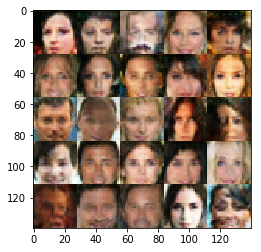

Epoch 2/3 -  Discriminator: 1.3013 -  Generator: 0.9170
Epoch 2/3 -  Discriminator: 1.5011 -  Generator: 0.4874
Epoch 2/3 -  Discriminator: 1.8867 -  Generator: 0.2846
Epoch 2/3 -  Discriminator: 1.7740 -  Generator: 0.3162
Epoch 2/3 -  Discriminator: 1.1906 -  Generator: 0.8089


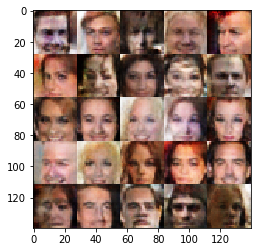

Epoch 2/3 -  Discriminator: 1.6443 -  Generator: 0.4191
Epoch 2/3 -  Discriminator: 1.3804 -  Generator: 0.7926
Epoch 2/3 -  Discriminator: 1.3088 -  Generator: 0.8007
Epoch 2/3 -  Discriminator: 1.2942 -  Generator: 0.6568
Epoch 2/3 -  Discriminator: 1.8406 -  Generator: 0.2800


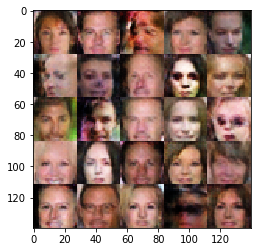

Epoch 2/3 -  Discriminator: 2.0837 -  Generator: 0.2278
Epoch 2/3 -  Discriminator: 1.7852 -  Generator: 0.3167
Epoch 2/3 -  Discriminator: 1.2938 -  Generator: 0.7762
Epoch 2/3 -  Discriminator: 1.7489 -  Generator: 0.3069
Epoch 2/3 -  Discriminator: 1.5651 -  Generator: 0.3919


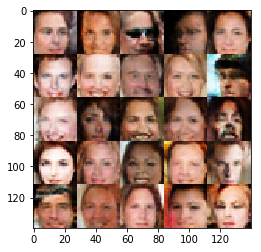

Epoch 2/3 -  Discriminator: 1.3150 -  Generator: 0.6574
Epoch 2/3 -  Discriminator: 1.3517 -  Generator: 0.6326
Epoch 2/3 -  Discriminator: 1.7696 -  Generator: 0.3322
Epoch 2/3 -  Discriminator: 1.6770 -  Generator: 0.3482
Epoch 2/3 -  Discriminator: 1.5195 -  Generator: 0.4386


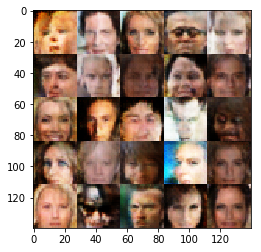

Epoch 2/3 -  Discriminator: 1.0747 -  Generator: 1.0230
Epoch 2/3 -  Discriminator: 1.8305 -  Generator: 0.2809
Epoch 2/3 -  Discriminator: 1.9228 -  Generator: 0.2663
Epoch 2/3 -  Discriminator: 1.3326 -  Generator: 1.0126
Epoch 2/3 -  Discriminator: 1.6368 -  Generator: 0.3552


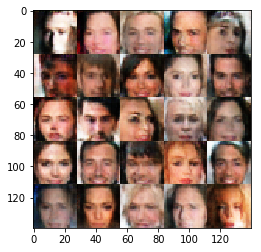

Epoch 2/3 -  Discriminator: 1.7919 -  Generator: 0.3454
Epoch 2/3 -  Discriminator: 1.3199 -  Generator: 0.5965
Epoch 2/3 -  Discriminator: 1.5993 -  Generator: 0.4468
Epoch 2/3 -  Discriminator: 1.7863 -  Generator: 0.3081
Epoch 2/3 -  Discriminator: 1.2676 -  Generator: 0.9878


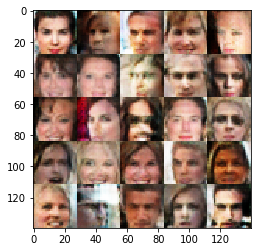

Epoch 2/3 -  Discriminator: 1.3520 -  Generator: 0.6292
Epoch 2/3 -  Discriminator: 1.6936 -  Generator: 0.3573
Epoch 2/3 -  Discriminator: 1.3020 -  Generator: 0.8742
Epoch 2/3 -  Discriminator: 1.4881 -  Generator: 0.4391
Epoch 2/3 -  Discriminator: 1.5247 -  Generator: 0.4085


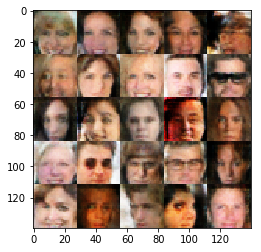

Epoch 2/3 -  Discriminator: 1.3791 -  Generator: 0.5780
Epoch 2/3 -  Discriminator: 1.6459 -  Generator: 0.3609
Epoch 2/3 -  Discriminator: 1.4905 -  Generator: 0.4669
Epoch 2/3 -  Discriminator: 1.3638 -  Generator: 0.7133
Epoch 2/3 -  Discriminator: 1.2320 -  Generator: 1.1415


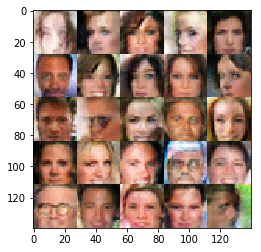

Epoch 2/3 -  Discriminator: 1.1997 -  Generator: 0.7657
Epoch 2/3 -  Discriminator: 1.2447 -  Generator: 0.8119
Epoch 2/3 -  Discriminator: 1.2025 -  Generator: 0.6557
Epoch 2/3 -  Discriminator: 1.5308 -  Generator: 0.4119
Epoch 2/3 -  Discriminator: 1.6526 -  Generator: 0.4047


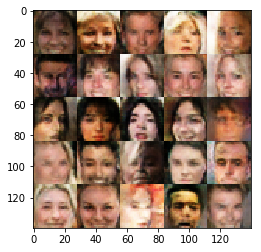

Epoch 2/3 -  Discriminator: 1.5464 -  Generator: 0.4326
Epoch 2/3 -  Discriminator: 1.7917 -  Generator: 0.2979
Epoch 2/3 -  Discriminator: 1.8276 -  Generator: 0.2833
Epoch 2/3 -  Discriminator: 1.3850 -  Generator: 0.6166
Epoch 2/3 -  Discriminator: 1.6750 -  Generator: 0.3895


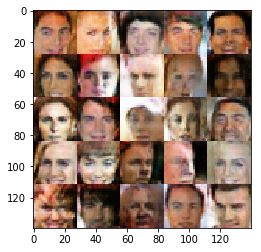

Epoch 2/3 -  Discriminator: 1.7413 -  Generator: 0.3322
Epoch 2/3 -  Discriminator: 1.6832 -  Generator: 0.4157
Epoch 2/3 -  Discriminator: 1.7954 -  Generator: 0.3172
Epoch 2/3 -  Discriminator: 1.3636 -  Generator: 0.6794
Epoch 2/3 -  Discriminator: 1.4562 -  Generator: 0.4571


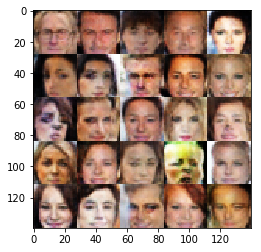

Epoch 2/3 -  Discriminator: 1.0924 -  Generator: 0.7758
Epoch 2/3 -  Discriminator: 1.8575 -  Generator: 0.2708
Epoch 2/3 -  Discriminator: 1.4175 -  Generator: 0.5440
Epoch 2/3 -  Discriminator: 1.4026 -  Generator: 0.6441
Epoch 2/3 -  Discriminator: 1.3726 -  Generator: 0.6708


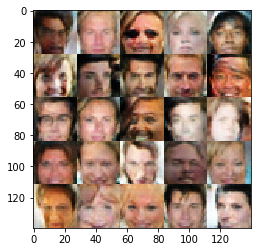

Epoch 2/3 -  Discriminator: 1.2074 -  Generator: 0.9043
Epoch 2/3 -  Discriminator: 0.9832 -  Generator: 1.2534
Epoch 2/3 -  Discriminator: 1.8064 -  Generator: 0.3368
Epoch 2/3 -  Discriminator: 1.2774 -  Generator: 0.6616
Epoch 2/3 -  Discriminator: 1.1671 -  Generator: 0.8885


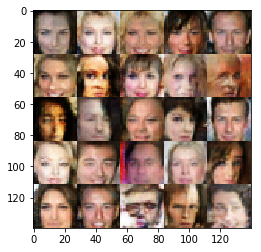

Epoch 2/3 -  Discriminator: 1.3982 -  Generator: 0.6459
Epoch 2/3 -  Discriminator: 1.5484 -  Generator: 0.4447
Epoch 2/3 -  Discriminator: 1.5068 -  Generator: 0.4607
Epoch 2/3 -  Discriminator: 1.3955 -  Generator: 0.5446
Epoch 2/3 -  Discriminator: 1.6790 -  Generator: 0.3461


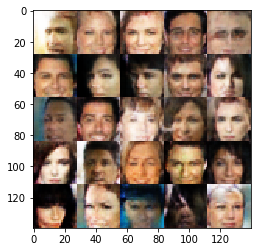

Epoch 2/3 -  Discriminator: 1.7976 -  Generator: 0.3005
Epoch 2/3 -  Discriminator: 1.7320 -  Generator: 0.3140
Epoch 2/3 -  Discriminator: 1.8198 -  Generator: 0.2823
Epoch 2/3 -  Discriminator: 1.2551 -  Generator: 0.8609
Epoch 2/3 -  Discriminator: 1.3611 -  Generator: 0.6988


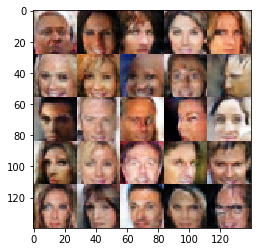

Epoch 2/3 -  Discriminator: 1.5211 -  Generator: 0.5190
Epoch 2/3 -  Discriminator: 2.0134 -  Generator: 0.2316
Epoch 2/3 -  Discriminator: 1.1233 -  Generator: 0.8942
Epoch 2/3 -  Discriminator: 1.4797 -  Generator: 0.4565
Epoch 2/3 -  Discriminator: 1.8628 -  Generator: 0.2930


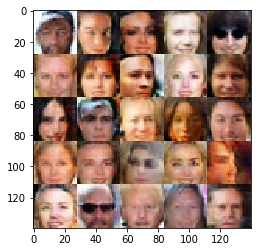

Epoch 2/3 -  Discriminator: 1.3821 -  Generator: 0.7044
Epoch 2/3 -  Discriminator: 1.8429 -  Generator: 0.2961
Epoch 2/3 -  Discriminator: 1.8353 -  Generator: 0.3130
Epoch 2/3 -  Discriminator: 1.7393 -  Generator: 0.3180
Epoch 2/3 -  Discriminator: 1.4479 -  Generator: 0.4715


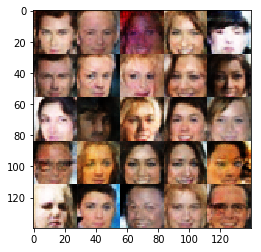

Epoch 2/3 -  Discriminator: 1.3372 -  Generator: 0.6175
Epoch 2/3 -  Discriminator: 1.3297 -  Generator: 0.6323
Epoch 2/3 -  Discriminator: 1.1756 -  Generator: 1.1301
Epoch 2/3 -  Discriminator: 1.3808 -  Generator: 0.6277
Epoch 2/3 -  Discriminator: 1.3338 -  Generator: 0.7330


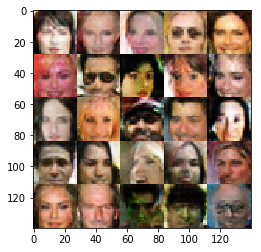

Epoch 2/3 -  Discriminator: 2.1906 -  Generator: 0.1924
Epoch 2/3 -  Discriminator: 1.6162 -  Generator: 0.3762
Epoch 2/3 -  Discriminator: 1.4052 -  Generator: 0.7675
Epoch 2/3 -  Discriminator: 1.3631 -  Generator: 0.5637
Epoch 2/3 -  Discriminator: 1.5342 -  Generator: 0.4678


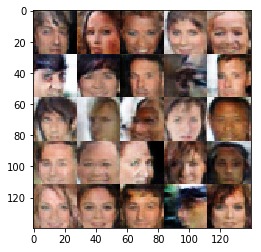

Epoch 2/3 -  Discriminator: 1.1285 -  Generator: 0.9440
Epoch 2/3 -  Discriminator: 1.5465 -  Generator: 0.4761
Epoch 2/3 -  Discriminator: 1.8662 -  Generator: 0.2859
Epoch 2/3 -  Discriminator: 1.7061 -  Generator: 0.3425
Epoch 2/3 -  Discriminator: 1.8061 -  Generator: 0.2829


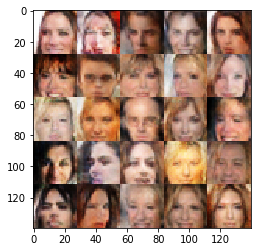

Epoch 2/3 -  Discriminator: 1.1078 -  Generator: 0.9539
Epoch 3/3 -  Discriminator: 1.6823 -  Generator: 0.3876
Epoch 3/3 -  Discriminator: 1.3111 -  Generator: 0.5983
Epoch 3/3 -  Discriminator: 1.3537 -  Generator: 0.6128
Epoch 3/3 -  Discriminator: 2.2265 -  Generator: 0.1975


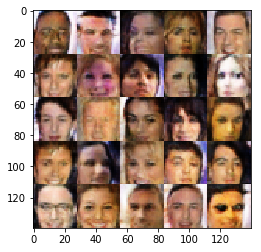

Epoch 3/3 -  Discriminator: 1.6158 -  Generator: 0.4324
Epoch 3/3 -  Discriminator: 1.3179 -  Generator: 0.9637
Epoch 3/3 -  Discriminator: 1.3255 -  Generator: 0.9325
Epoch 3/3 -  Discriminator: 2.0278 -  Generator: 0.2365
Epoch 3/3 -  Discriminator: 1.3950 -  Generator: 0.5671


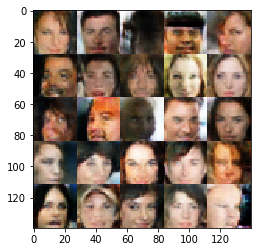

Epoch 3/3 -  Discriminator: 1.3075 -  Generator: 0.7168
Epoch 3/3 -  Discriminator: 1.8459 -  Generator: 0.2856
Epoch 3/3 -  Discriminator: 2.3819 -  Generator: 0.1584
Epoch 3/3 -  Discriminator: 1.7957 -  Generator: 0.3028
Epoch 3/3 -  Discriminator: 1.7767 -  Generator: 0.3004


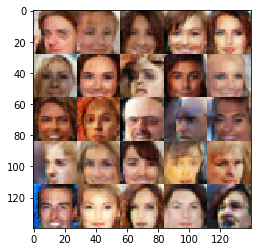

Epoch 3/3 -  Discriminator: 1.3619 -  Generator: 0.6055
Epoch 3/3 -  Discriminator: 1.9734 -  Generator: 0.2505
Epoch 3/3 -  Discriminator: 1.7965 -  Generator: 0.3007
Epoch 3/3 -  Discriminator: 1.9307 -  Generator: 0.2583
Epoch 3/3 -  Discriminator: 1.3122 -  Generator: 0.8928


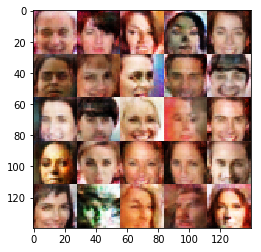

Epoch 3/3 -  Discriminator: 1.9588 -  Generator: 0.2427
Epoch 3/3 -  Discriminator: 2.5608 -  Generator: 0.1330
Epoch 3/3 -  Discriminator: 1.8780 -  Generator: 0.2690
Epoch 3/3 -  Discriminator: 1.2479 -  Generator: 0.6824
Epoch 3/3 -  Discriminator: 1.5254 -  Generator: 0.4253


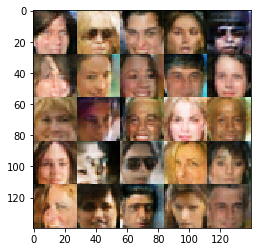

Epoch 3/3 -  Discriminator: 1.5281 -  Generator: 0.4820
Epoch 3/3 -  Discriminator: 1.9255 -  Generator: 0.2636
Epoch 3/3 -  Discriminator: 1.2503 -  Generator: 1.0908
Epoch 3/3 -  Discriminator: 1.7482 -  Generator: 0.3084
Epoch 3/3 -  Discriminator: 1.3457 -  Generator: 0.7219


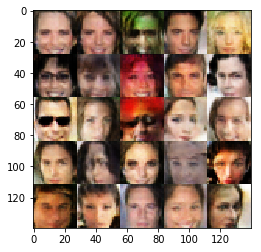

Epoch 3/3 -  Discriminator: 1.6028 -  Generator: 0.3808
Epoch 3/3 -  Discriminator: 1.2068 -  Generator: 0.9626
Epoch 3/3 -  Discriminator: 1.7022 -  Generator: 0.3712
Epoch 3/3 -  Discriminator: 1.9764 -  Generator: 0.2623
Epoch 3/3 -  Discriminator: 1.6938 -  Generator: 0.3390


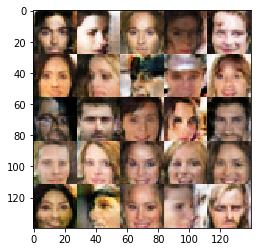

Epoch 3/3 -  Discriminator: 1.3409 -  Generator: 1.5458
Epoch 3/3 -  Discriminator: 1.2355 -  Generator: 0.6735
Epoch 3/3 -  Discriminator: 1.9292 -  Generator: 0.2785
Epoch 3/3 -  Discriminator: 1.7904 -  Generator: 0.3033
Epoch 3/3 -  Discriminator: 1.3506 -  Generator: 0.5592


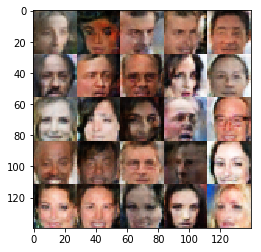

Epoch 3/3 -  Discriminator: 1.5562 -  Generator: 0.4502
Epoch 3/3 -  Discriminator: 1.7068 -  Generator: 0.4073
Epoch 3/3 -  Discriminator: 2.1991 -  Generator: 0.1931
Epoch 3/3 -  Discriminator: 1.9483 -  Generator: 0.2407
Epoch 3/3 -  Discriminator: 1.0848 -  Generator: 1.1305


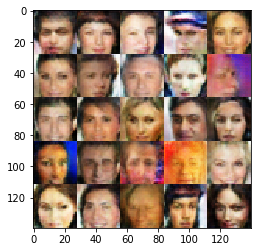

Epoch 3/3 -  Discriminator: 1.2751 -  Generator: 0.8423
Epoch 3/3 -  Discriminator: 1.6757 -  Generator: 0.3551
Epoch 3/3 -  Discriminator: 1.6374 -  Generator: 0.3971
Epoch 3/3 -  Discriminator: 1.4446 -  Generator: 0.4931
Epoch 3/3 -  Discriminator: 2.1114 -  Generator: 0.2234


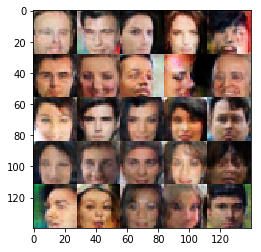

Epoch 3/3 -  Discriminator: 1.3264 -  Generator: 0.5851
Epoch 3/3 -  Discriminator: 1.5482 -  Generator: 0.4463
Epoch 3/3 -  Discriminator: 1.7348 -  Generator: 0.3925
Epoch 3/3 -  Discriminator: 1.4927 -  Generator: 0.4315
Epoch 3/3 -  Discriminator: 1.2626 -  Generator: 0.7129


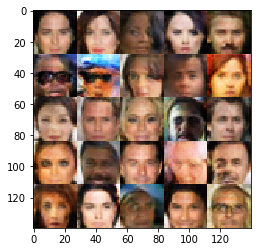

Epoch 3/3 -  Discriminator: 0.9968 -  Generator: 1.1237
Epoch 3/3 -  Discriminator: 1.9318 -  Generator: 0.2824
Epoch 3/3 -  Discriminator: 1.6607 -  Generator: 0.3786
Epoch 3/3 -  Discriminator: 1.7080 -  Generator: 0.3485
Epoch 3/3 -  Discriminator: 1.4274 -  Generator: 0.5422


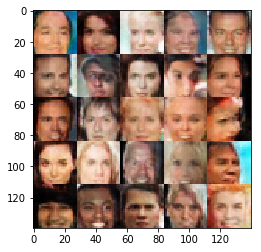

Epoch 3/3 -  Discriminator: 1.4877 -  Generator: 0.5274
Epoch 3/3 -  Discriminator: 1.2084 -  Generator: 0.7739
Epoch 3/3 -  Discriminator: 2.4514 -  Generator: 0.1503
Epoch 3/3 -  Discriminator: 1.3192 -  Generator: 0.6138
Epoch 3/3 -  Discriminator: 1.4479 -  Generator: 0.5098


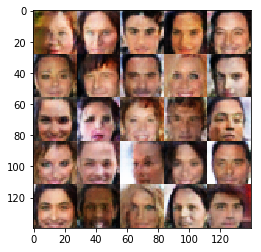

Epoch 3/3 -  Discriminator: 1.2035 -  Generator: 0.9501
Epoch 3/3 -  Discriminator: 1.7916 -  Generator: 0.3163
Epoch 3/3 -  Discriminator: 1.3373 -  Generator: 1.2718
Epoch 3/3 -  Discriminator: 1.3185 -  Generator: 1.5895
Epoch 3/3 -  Discriminator: 1.4118 -  Generator: 0.7313


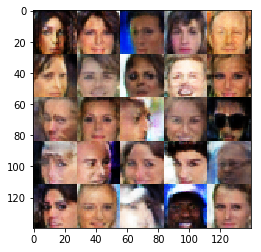

Epoch 3/3 -  Discriminator: 1.4610 -  Generator: 0.4623
Epoch 3/3 -  Discriminator: 1.4538 -  Generator: 0.4336
Epoch 3/3 -  Discriminator: 1.2849 -  Generator: 0.6220
Epoch 3/3 -  Discriminator: 1.4892 -  Generator: 1.3323
Epoch 3/3 -  Discriminator: 1.3108 -  Generator: 0.5596


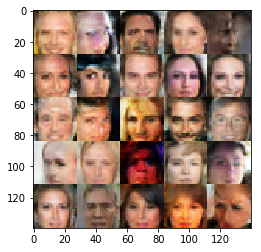

Epoch 3/3 -  Discriminator: 1.5555 -  Generator: 0.4642
Epoch 3/3 -  Discriminator: 1.2445 -  Generator: 1.0846
Epoch 3/3 -  Discriminator: 2.3508 -  Generator: 0.1705
Epoch 3/3 -  Discriminator: 1.8462 -  Generator: 0.2733
Epoch 3/3 -  Discriminator: 1.3684 -  Generator: 0.5356


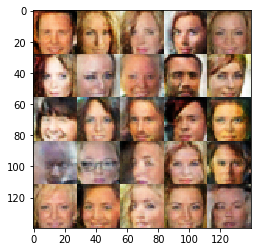

Epoch 3/3 -  Discriminator: 1.2635 -  Generator: 0.7599
Epoch 3/3 -  Discriminator: 1.9364 -  Generator: 0.2667
Epoch 3/3 -  Discriminator: 1.5638 -  Generator: 0.4127
Epoch 3/3 -  Discriminator: 1.9102 -  Generator: 0.2569
Epoch 3/3 -  Discriminator: 2.0830 -  Generator: 0.2221


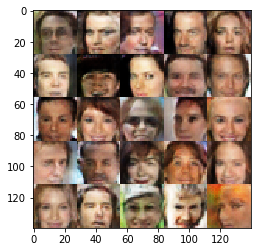

Epoch 3/3 -  Discriminator: 2.2474 -  Generator: 0.1873
Epoch 3/3 -  Discriminator: 1.0532 -  Generator: 1.3992
Epoch 3/3 -  Discriminator: 1.7619 -  Generator: 0.3432
Epoch 3/3 -  Discriminator: 1.2821 -  Generator: 0.7118
Epoch 3/3 -  Discriminator: 2.1220 -  Generator: 0.2131


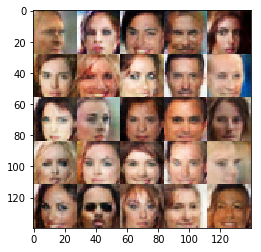

Epoch 3/3 -  Discriminator: 1.4532 -  Generator: 0.8351
Epoch 3/3 -  Discriminator: 1.7272 -  Generator: 0.3288
Epoch 3/3 -  Discriminator: 1.5076 -  Generator: 0.5478
Epoch 3/3 -  Discriminator: 1.2723 -  Generator: 0.6295
Epoch 3/3 -  Discriminator: 1.6818 -  Generator: 0.3467


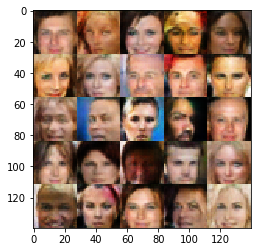

Epoch 3/3 -  Discriminator: 1.7220 -  Generator: 0.3270
Epoch 3/3 -  Discriminator: 1.5405 -  Generator: 0.4351
Epoch 3/3 -  Discriminator: 1.2731 -  Generator: 0.8678
Epoch 3/3 -  Discriminator: 1.2791 -  Generator: 0.7378
Epoch 3/3 -  Discriminator: 1.3708 -  Generator: 1.1261


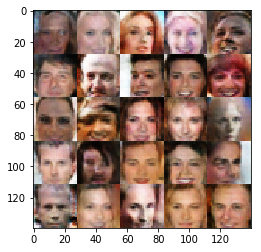

Epoch 3/3 -  Discriminator: 1.5378 -  Generator: 0.3988
Epoch 3/3 -  Discriminator: 1.5852 -  Generator: 0.3981
Epoch 3/3 -  Discriminator: 2.2002 -  Generator: 0.1890
Epoch 3/3 -  Discriminator: 1.4567 -  Generator: 0.6494
Epoch 3/3 -  Discriminator: 1.4802 -  Generator: 0.4816


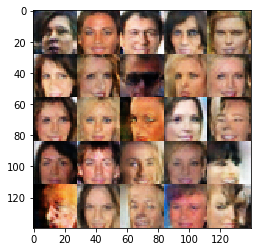

Epoch 3/3 -  Discriminator: 1.5641 -  Generator: 0.4647
Epoch 3/3 -  Discriminator: 1.5831 -  Generator: 0.4554
Epoch 3/3 -  Discriminator: 2.5585 -  Generator: 0.1419
Epoch 3/3 -  Discriminator: 1.8275 -  Generator: 0.3135
Epoch 3/3 -  Discriminator: 1.8685 -  Generator: 0.3114


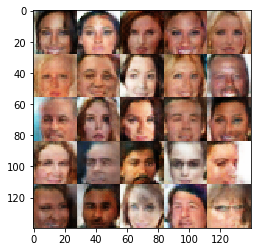

Epoch 3/3 -  Discriminator: 1.9912 -  Generator: 0.2389
Epoch 3/3 -  Discriminator: 1.7825 -  Generator: 0.3152
Epoch 3/3 -  Discriminator: 2.1864 -  Generator: 0.2101
Epoch 3/3 -  Discriminator: 1.5742 -  Generator: 0.5139
Epoch 3/3 -  Discriminator: 1.6592 -  Generator: 0.3665


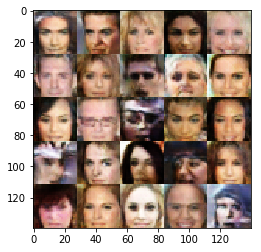

Epoch 3/3 -  Discriminator: 1.9065 -  Generator: 0.2895
Epoch 3/3 -  Discriminator: 2.3431 -  Generator: 0.1765
Epoch 3/3 -  Discriminator: 2.6947 -  Generator: 0.1174
Epoch 3/3 -  Discriminator: 2.3659 -  Generator: 0.1665
Epoch 3/3 -  Discriminator: 1.1308 -  Generator: 0.7620


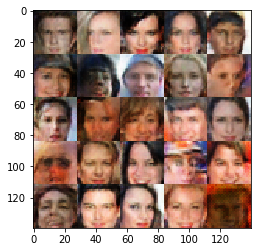

Epoch 3/3 -  Discriminator: 1.4220 -  Generator: 0.5154
Epoch 3/3 -  Discriminator: 1.4960 -  Generator: 0.5301
Epoch 3/3 -  Discriminator: 1.7253 -  Generator: 0.3413
Epoch 3/3 -  Discriminator: 2.2457 -  Generator: 0.1836
Epoch 3/3 -  Discriminator: 1.8209 -  Generator: 0.3092


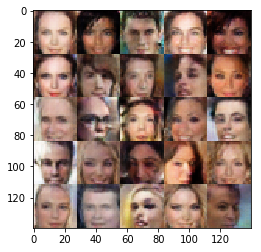

Epoch 3/3 -  Discriminator: 2.3084 -  Generator: 0.1700
Epoch 3/3 -  Discriminator: 1.4890 -  Generator: 0.4680
Epoch 3/3 -  Discriminator: 1.4090 -  Generator: 0.7106
Epoch 3/3 -  Discriminator: 1.8587 -  Generator: 0.2761
Epoch 3/3 -  Discriminator: 1.4451 -  Generator: 0.5577


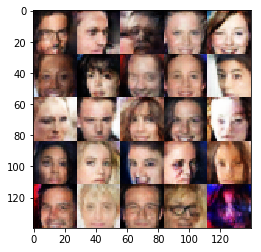

Epoch 3/3 -  Discriminator: 1.5909 -  Generator: 0.3818
Epoch 3/3 -  Discriminator: 1.9745 -  Generator: 0.2500
Epoch 3/3 -  Discriminator: 2.0590 -  Generator: 0.2332
Epoch 3/3 -  Discriminator: 1.4325 -  Generator: 1.5089
Epoch 3/3 -  Discriminator: 1.5365 -  Generator: 0.4315


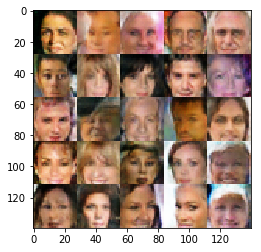

Epoch 3/3 -  Discriminator: 1.6578 -  Generator: 0.5149
Epoch 3/3 -  Discriminator: 2.1871 -  Generator: 0.2064
Epoch 3/3 -  Discriminator: 1.7588 -  Generator: 2.5644
Epoch 3/3 -  Discriminator: 1.6081 -  Generator: 0.3900
Epoch 3/3 -  Discriminator: 1.5190 -  Generator: 0.4491


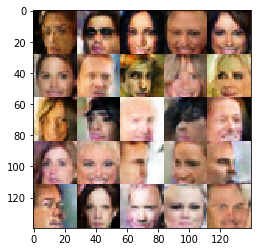

Epoch 3/3 -  Discriminator: 1.2559 -  Generator: 0.8925
Epoch 3/3 -  Discriminator: 1.6921 -  Generator: 0.3331
Epoch 3/3 -  Discriminator: 2.3200 -  Generator: 0.1686
Epoch 3/3 -  Discriminator: 2.3096 -  Generator: 0.1712
Epoch 3/3 -  Discriminator: 1.5858 -  Generator: 0.4670


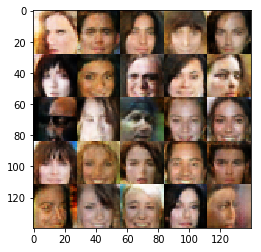

Epoch 3/3 -  Discriminator: 1.6423 -  Generator: 0.3821
Epoch 3/3 -  Discriminator: 2.9238 -  Generator: 0.0861
Epoch 3/3 -  Discriminator: 1.2979 -  Generator: 0.7191
Epoch 3/3 -  Discriminator: 2.9159 -  Generator: 0.0916
Epoch 3/3 -  Discriminator: 1.3136 -  Generator: 0.6552


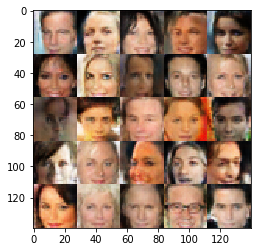

Epoch 3/3 -  Discriminator: 1.8399 -  Generator: 0.2945
Epoch 3/3 -  Discriminator: 2.2597 -  Generator: 0.1950
Epoch 3/3 -  Discriminator: 1.5222 -  Generator: 0.5224
Epoch 3/3 -  Discriminator: 1.9010 -  Generator: 0.2753
Epoch 3/3 -  Discriminator: 1.6443 -  Generator: 0.3785


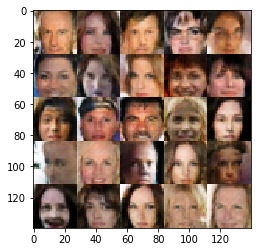

Epoch 3/3 -  Discriminator: 1.3999 -  Generator: 0.4774
Epoch 3/3 -  Discriminator: 1.4751 -  Generator: 0.4685
Epoch 3/3 -  Discriminator: 2.2223 -  Generator: 0.1873
Epoch 3/3 -  Discriminator: 1.2718 -  Generator: 0.7593


In [14]:
batch_size = 64
z_dim = 256
learning_rate = 0.001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 3

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.